## Project: Decision Tracker
## Making informed decisions based on personal data
**Source:** Own files

### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [4]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath('/'))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [5]:
import requests # to download data from api
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pathlib # for path functions
import numpy as np

import sqlite3
import seaborn as sns

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

In [6]:
# PARAMETERS
plt.style.use('fivethirtyeight')

In [7]:
DataFolderPath = pathlib.Path(os.path.dirname(os.path.realpath(''))).parent
print(DataFolderPath)

C:\Users\tgusc\Documents\GitHub


In [8]:
# filename = 'Wydatki_2021.xlsx'
# file = os.path.join(DataFolderPath, 'Private', filename)

In [ ]:
# Unused SQL Queries - move to beggining


# 3. Przygotowanie agregacji danych
# Miesięczne wpływy
# query_monthly_income = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wplywy FROM transactions WHERE Rodzaj = 'Credit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_income_by_type = pd.read_sql(query_monthly_income, conn)

# Miesięczne wydatki
# query_monthly_expenses = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki FROM transactions WHERE Rodzaj = 'Debit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Miesięczne przepływy
# query_monthly_flow = "SELECT Rok, Miesiac, SUM(Case When Rodzaj = 'Credit' THEN Cena ELSE 0 END) as Wplywy, SUM(Case When Rodzaj = 'Debit' THEN Cena ELSE 0 END) as Wydatki FROM transactions GROUP BY Rok, Miesiac"
# monthly_flow = pd.read_sql(query_monthly_flow, conn)
# monthly_flow["Przeplywy"] = monthly_flow["Wplywy"] + monthly_flow["Wydatki"]

# Analiza miesięcznej struktury wydatków
# monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# 4. Przygotowanie danych kumulatywnych
# Kumulacyjne wpływy
# monthly_income_by_type['Kumulacyjne_Wplywy'] = monthly_income_by_type.groupby(['Rok', 'Kategoria'])['Wplywy'].cumsum()

# Kumulacyjne wydatki
# monthly_expenses_by_type['Kumulacyjne_Wydatki'] = monthly_expenses_by_type.groupby(['Rok', 'Kategoria'])['Wydatki'].cumsum()

# Kumulacyjne przepływy
# monthly_flow['Kumulacyjne_Wplywy'] = monthly_flow.groupby('Rok')['Wplywy'].cumsum()
# monthly_flow['Kumulacyjne_Wydatki'] = monthly_flow.groupby('Rok')['Wydatki'].cumsum()
# monthly_flow['Kumulacyjne_Przeplywy'] = monthly_flow['Kumulacyjne_Wplywy'] + monthly_flow['Kumulacyjne_Wydatki']

# Kumulacyjna analiza struktury wydatków
# cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Kumulacyjne_Wydatki'].sum().reset_index()
# cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Kumulacyjne_Wydatki': 'Suma_Kumulacyjnych_Wydatkow'})
# cumulative_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
# cumulative_expenses_structure['Procent_Kumulacyjny'] = cumulative_expenses_structure['Kumulacyjne_Wydatki'] / cumulative_expenses_structure['Suma_Kumulacyjnych_Wydatkow'] 


In [11]:
def import_bills(filename, sheet_name):
    # Necessary requirements - DataFolderPath
    file = os.path.join(DataFolderPath, 'Private', filename)
    data_in = pd.read_excel(file, sheet_name = sheet_name , decimal=',')
    data_out = data_in
    data_out["LP"] = data_in["LP"].astype(np.int32)
    data_out["Rok"] = data_in["Rok"].astype(np.int32)
    data_out["Miesiac"] = data_in["Miesiac"].astype(np.int32)
    data_out["Data"] = pd.to_datetime(data_in["Data"])
    data_out["Cena"] = data_in["Cena"].replace(',','.').astype(float)
    if "Nr koszyka" in data_in.columns:
        data_out["Nr koszyka"] = data_in["Nr koszyka"].astype(str)

    # Cleaning data
    data_out = data_out[data_out["Rok"] != 1900].copy() # usuwanie wierszy bez dat
    data_out = data_out[data_out["Kategoria"].notna()].copy()

    def clean_category(category):
        return category.lower().strip()

    # Oczyszczanie nazw kategorii
    data_out['Kategoria'] = data_out['Kategoria'].apply(clean_category)

    print(data_out.tail()) # sample check
    return data_out



In [14]:
wydatki = import_bills(filename = 'Wydatki_2021.xlsx', sheet_name = 'Wydatki')

        LP       Data                    Przedmiot      Cena Waluta  \
4816  4750 2023-09-17            Kama - do koperty    -20.00    PLN   
4817  4751 2023-09-17         Meatologia - napiwek    -40.00    PLN   
4818  4752 2023-09-19                      Spotify    -19.99    PLN   
4819  4753 2023-09-19            Klucz Office 2010    -44.00    PLN   
4820  4754 2023-08-09  Pensja SCS Expert - 2023-08  29319.07    PLN   

                   Sklep             Miejsce Nr koszyka            Skad  \
4816                Inne                Kama     3722.0  Mbank Debetowa   
4817          Meatologia     Warszawa Krucza     3723.0  Mbank Debetowa   
4818             Spotify             Spotify     3724.0  Citi Kredytowa   
4819  software-klucze.pl  software-klucze.pl     3725.0  Citi Kredytowa   
4820          SCS Expert          Alior Bank     3726.0   Alior Firmowa   

        Potrzeba                     Kategoria     Grupa   Rok  Miesiac  \
4816  Zachcianka                       prezent 

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [15]:
wydatki_wspolne = import_bills(filename = 'Wydatki_2021.xlsx', sheet_name = 'Wydatki_KontoWspolne')

        LP       Data                   Przedmiot   Cena Waluta  Sklep    Kto  \
1198  1199 2023-09-20  Zakupy do Siwka - piwa itp -18.40    PLN  Żabka    Ada   
1199  1200 2023-09-20                        Uber -26.20    PLN   Uber  Tomek   
1200  1201 2023-09-20                        Uber -29.38    PLN   Uber  Tomek   
1201  1202 2023-09-21  Zakupy do Siwka - piwa itp  -4.30    PLN  Żabka    Ada   
1202  1203 2023-09-21  Zakupy do Siwka - piwa itp -35.47    PLN  Żabka    Ada   

        Potrzeba                    Kategoria     Grupa   Rok  Miesiac Rodzaj  \
1198  Zachcianka                      prezent   Grupa V  2023        9  Debit   
1199  Zachcianka                         taxi  Grupa IV  2023        9  Debit   
1200  Zachcianka                         taxi  Grupa IV  2023        9  Debit   
1201  Zachcianka  jedzenie i picie: niezdrowe  Grupa IV  2023        9  Debit   
1202  Zachcianka  jedzenie i picie: niezdrowe  Grupa IV  2023        9  Debit   

     Komentarz  
1198     

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [20]:
def sql_sum(data_in):
    # 2. Stworzenie lokalnej bazy danych SQLite
    conn = sqlite3.connect('transactions_db.sqlite')
    data_in.to_sql('transactions', conn, if_exists='replace', index=False)
    conn.commit()

    # Przygotowanie agregacji danych
    query_sum = "SELECT Rok, Miesiac, Rodzaj, Kategoria, SUM(Cena) AS Suma FROM transactions GROUP BY Rok, Miesiac, Kategoria, Rodzaj"
    data_out = pd.read_sql(query_sum, conn)
    print(data_out.tail())
    return data_out

In [21]:
monthly_wydatki = sql_sum(wydatki)

       Rok  Miesiac  Rodzaj                       Kategoria     Suma
1035  2023        9   Debit         rozrywka i przyjemności   -79.99
1036  2023        9   Debit                       transport    -6.80
1037  2023        9   Debit          wspólny rachunek - ada -9565.23
1038  2023        9  Credit  własny rozwój (kursy, zajęcia)  1063.98
1039  2023        9   Debit  własny rozwój (kursy, zajęcia) -4735.45


In [22]:
monthly_wspolne = sql_sum(wydatki_wspolne)

      Rok  Miesiac Rodzaj                       Kategoria    Suma
275  2023        9  Debit         rozrywka i przyjemności -618.99
276  2023        9  Debit                       szastusia -243.17
277  2023        9  Debit                            taxi -129.58
278  2023        9  Debit                       transport  -17.00
279  2023        9  Debit  własny rozwój (kursy, zajęcia)  -40.00


In [17]:
# Unused SQL Queries - move to beggining


# 3. Przygotowanie agregacji danych
# Miesięczne wpływy
# query_monthly_income = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wplywy FROM transactions WHERE Rodzaj = 'Credit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_income_by_type = pd.read_sql(query_monthly_income, conn)

# Miesięczne wydatki
# query_monthly_expenses = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki FROM transactions WHERE Rodzaj = 'Debit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Miesięczne przepływy
# query_monthly_flow = "SELECT Rok, Miesiac, SUM(Case When Rodzaj = 'Credit' THEN Cena ELSE 0 END) as Wplywy, SUM(Case When Rodzaj = 'Debit' THEN Cena ELSE 0 END) as Wydatki FROM transactions GROUP BY Rok, Miesiac"
# monthly_flow = pd.read_sql(query_monthly_flow, conn)
# monthly_flow["Przeplywy"] = monthly_flow["Wplywy"] + monthly_flow["Wydatki"]

# Analiza miesięcznej struktury wydatków
# monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# 4. Przygotowanie danych kumulatywnych
# Kumulacyjne wpływy
# monthly_income_by_type['Kumulacyjne_Wplywy'] = monthly_income_by_type.groupby(['Rok', 'Kategoria'])['Wplywy'].cumsum()

# Kumulacyjne wydatki
# monthly_expenses_by_type['Kumulacyjne_Wydatki'] = monthly_expenses_by_type.groupby(['Rok', 'Kategoria'])['Wydatki'].cumsum()

# Kumulacyjne przepływy
# monthly_flow['Kumulacyjne_Wplywy'] = monthly_flow.groupby('Rok')['Wplywy'].cumsum()
# monthly_flow['Kumulacyjne_Wydatki'] = monthly_flow.groupby('Rok')['Wydatki'].cumsum()
# monthly_flow['Kumulacyjne_Przeplywy'] = monthly_flow['Kumulacyjne_Wplywy'] + monthly_flow['Kumulacyjne_Wydatki']

# Kumulacyjna analiza struktury wydatków
# cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Kumulacyjne_Wydatki'].sum().reset_index()
# cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Kumulacyjne_Wydatki': 'Suma_Kumulacyjnych_Wydatkow'})
# cumulative_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
# cumulative_expenses_structure['Procent_Kumulacyjny'] = cumulative_expenses_structure['Kumulacyjne_Wydatki'] / cumulative_expenses_structure['Suma_Kumulacyjnych_Wydatkow'] 


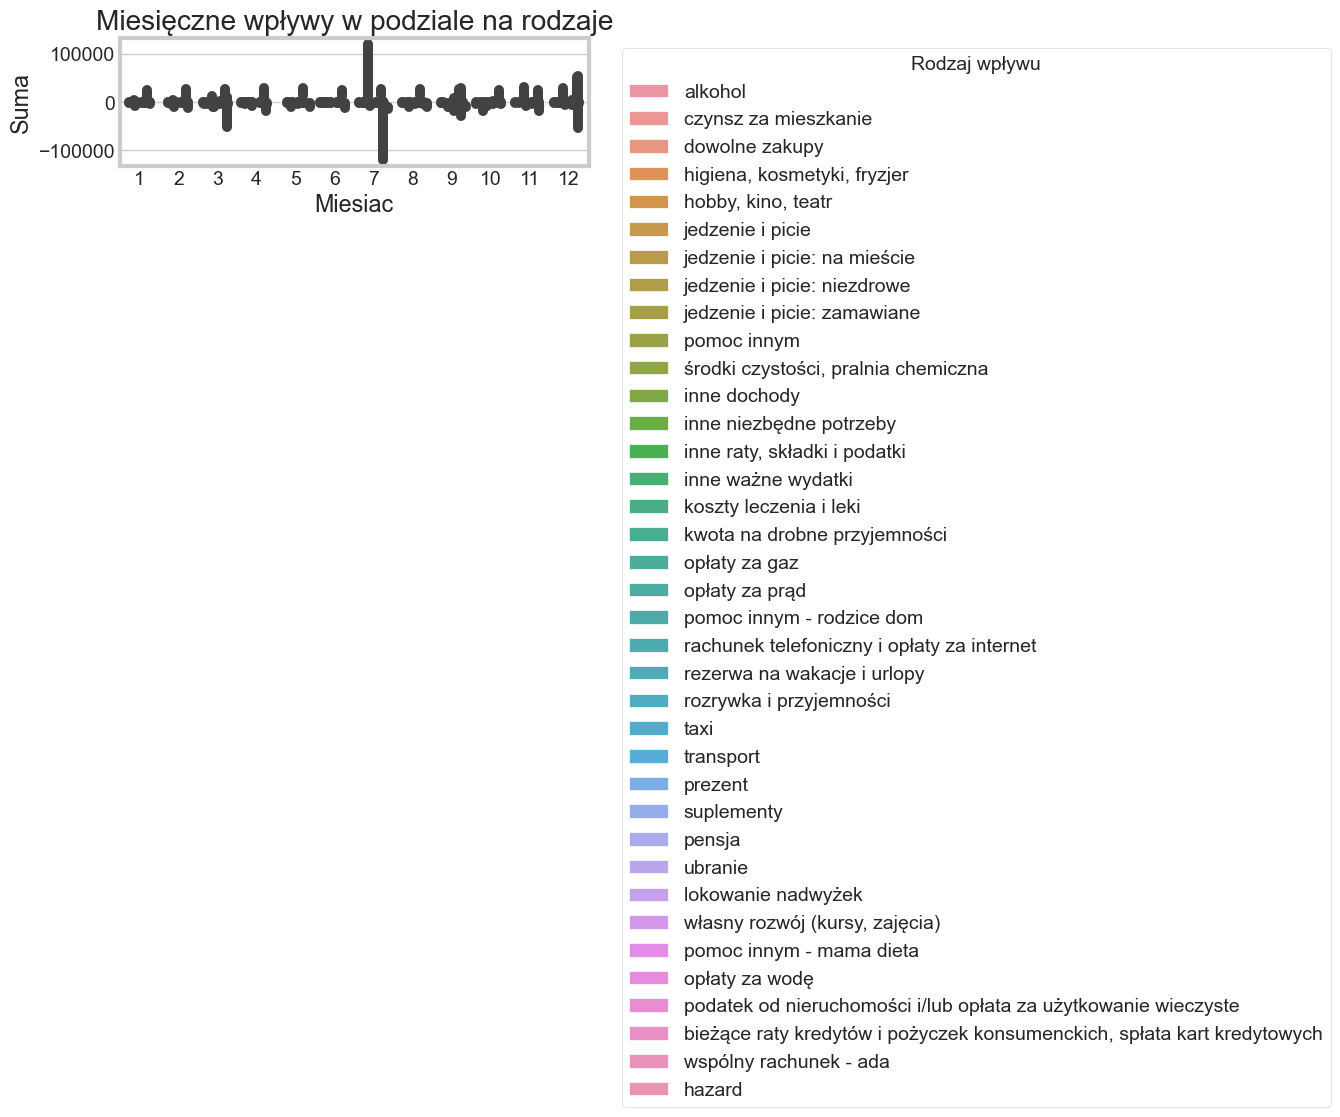

In [24]:
# TBD - moze zostawimy

# 5. Tworzenie wykresów
sns.set_style("whitegrid")

# Wykres miesięcznych wpływów
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_wydatki, x='Miesiac', y='Suma', hue='Kategoria')
plt.title('Miesięczne wpływy w podziale na rodzaje')
plt.legend(title='Rodzaj wpływu', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [18]:
# https://www.google.com/search?client=firefox-b-d&q=vs+code+interactive+plots+in+python#ip=1

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

def final_plot_with_larger_table(years, months, rodzaje):
    # Filtrujemy dane według wybranych lat, miesięcy i rodzajów transakcji
    data_in = monthly_data[
        monthly_data['Rok'].isin(years) & 
        monthly_data['Miesiac'].isin(months) & 
        monthly_data['Rodzaj'].isin(rodzaje)
    ].sort_values('Suma')  # Sortowanie słupków od najmniejszego do największego
    
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=data_in, x='Miesiac', y='Suma', hue='Kategoria', order=data_in['Miesiac'].unique())
    
    # Dodajemy etykiety do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                    ha='center', va='center', 
                    xytext=(0, -10), 
                    textcoords='offset points')
    
    plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
    
    # Przenoszenie legendy pod wykres
    ax.legend(title='Kategoria', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
    
    plt.tight_layout()
    
    plt.show()

available_years = sorted(monthly_data['Rok'].unique())
available_months = sorted(monthly_data['Miesiac'].unique())
available_rodzaje = sorted(monthly_data['Rodzaj'].unique())

default_year = max(available_years)
default_rodzaj = "Debit"
default_month = max(monthly_data[monthly_data['Rok']==default_year]["Miesiac"])

# Uaktualnienie widgetu z wielokrotnym wyborem wartości
widgets.interact(
    final_plot_with_larger_table, 
    years=widgets.SelectMultiple(options=available_years, description='Rok:', value=(default_year,)), 
    months=widgets.SelectMultiple(options=available_months, description='Miesiąc:', value=(default_month,)),
    rodzaje=widgets.SelectMultiple(options=available_rodzaje, description='Rodzaj:', value=(default_rodzaj,))
)


interactive(children=(SelectMultiple(description='Rok:', index=(4,), options=(2019, 2020, 2021, 2022, 2023), v…

<function __main__.final_plot_with_larger_table(years, months, rodzaje)>

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

def plot_with_time_range_updated(categories, last_n_months, rodzaj):
    # Pobieranie najnowszej dostępnej daty
    latest_year = max(monthly_data['Rok'])
    latest_month = max(monthly_data[monthly_data['Rok'] == latest_year]["Miesiac"])
    
    # Określenie zakresu daty na podstawie last_n_months
    end_month = latest_month
    end_year = latest_year
    
    start_month = latest_month - last_n_months + 1
    start_year = latest_year
    while start_month <= 0:
        start_month += 12
        start_year -= 1

    # Filtrujemy dane według wybranego zakresu czasu, rodzaju i kategorii
    filtered_data = monthly_data[
        ((monthly_data['Rok'] > start_year) | 
         ((monthly_data['Rok'] == start_year) & (monthly_data['Miesiac'] >= start_month)) &
         ((monthly_data['Rok'] < end_year) |
         ((monthly_data['Rok'] == end_year) & (monthly_data['Miesiac'] <= end_month)))) &
        (monthly_data['Rodzaj'].isin(rodzaj)) &
        (monthly_data['Kategoria'].isin(categories))
    ]

    # Sumowanie danych dla wybranych kategorii
    summed_data = filtered_data.groupby(['Rok', 'Miesiac']).agg({'Suma': 'sum'}).reset_index()
    
    # Dodawanie kolumny "rok-miesiąc" do summed_data
    summed_data['Rok-Miesiac'] = summed_data['Rok'].astype(str) + "-" + summed_data['Miesiac'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(15, 8))
    
    # Tworzenie wykresu słupkowego
    ax = sns.barplot(data=summed_data, x='Rok-Miesiac', y='Suma')
    
    # Dodawanie etykiet do słupków
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                    ha='center', va='center', 
                    xytext=(0, -10), 
                    textcoords='offset points')
    
    plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
    plt.tight_layout()
    
    plt.show()

available_categories = sorted(list(set(monthly_data['Kategoria'].unique())))
available_types = sorted(list(set(monthly_data['Rodzaj'].unique())))
default_rodzaj = ("Debit",)

# Znalezienie najdłuższej kategorii
max_length_category = max(available_categories, key=len)

# Uruchamiam interaktywną wizualizację
widgets.interact(
    plot_with_time_range_updated, 
    categories=widgets.SelectMultiple(
        options=available_categories, 
        description='Kategoria:', 
        layout=widgets.Layout(width=f'{len(max_length_category) * 8 + 20}px', height=f'{int(len(available_categories)*25*0.85)}px'),
        value=available_categories  # Domyślnie zaznacz wszystkie kategorie
    ),
    last_n_months=widgets.Dropdown(options=[3, 6, 9, 12, 18, 24], description='Ostatnie miesiące:', value=6),
    rodzaj=widgets.SelectMultiple(options=available_types, description='Rodzaj:', value=default_rodzaj)
)


interactive(children=(SelectMultiple(description='Kategoria:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

<function __main__.plot_with_time_range_updated(categories, last_n_months, rodzaj)>

In [32]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output, display

monthly_data['Rok-Miesiac'] = monthly_data['Rok'].astype(str) + '-' + monthly_data['Miesiac'].astype(str).str.zfill(2)

# Ustalanie indeksów dla najnowszego roku w danych
current_year = monthly_data['Rok'].max()
start_idx = monthly_data[monthly_data['Rok'] == current_year]['Rok-Miesiac'].min()
end_idx = monthly_data[monthly_data['Rok'] == current_year]['Rok-Miesiac'].max()

# Widgety
date_range = widgets.SelectionRangeSlider(
    options=sorted(monthly_data['Rok-Miesiac'].unique()),
    index=(monthly_data['Rok-Miesiac'].unique().tolist().index(start_idx), 
           monthly_data['Rok-Miesiac'].unique().tolist().index(end_idx)),
    description='Zakres dat:',
    continuous_update=False,
    layout=widgets.Layout(width='500px')
)

category_selector = widgets.SelectMultiple(
    options=sorted(monthly_data['Kategoria'].unique()),
    value=list(monthly_data['Kategoria'].unique()),
    description='Kategoria:',
    continuous_update=False,
    rows=len(monthly_data['Kategoria'].unique()),
    layout=widgets.Layout(width='1000px')
)

type_selector = widgets.SelectMultiple(
    options=sorted(monthly_data['Rodzaj'].unique()),
    value=['Debit'],
    description='Rodzaj:',
    continuous_update=False,
    rows=len(monthly_data['Rodzaj'].unique())
)

output = widgets.Output()

def update_table(change=None):
    with output:
        clear_output(wait=True)
        filtered_data = monthly_data[
            (monthly_data['Rok-Miesiac'] >= date_range.value[0]) &
            (monthly_data['Rok-Miesiac'] <= date_range.value[1]) &
            (monthly_data['Kategoria'].isin(category_selector.value)) &
            (monthly_data['Rodzaj'].isin(type_selector.value))
        ]
        pivot = filtered_data.pivot_table(index='Kategoria', columns='Rok-Miesiac', values='Suma', aggfunc='sum').fillna(0).sort_index()
        
        # Zaokrąglenie do 2 miejsc po przecinku
        pivot = pivot.round(2)
        
        # Dodanie kolumny "Sum_total"
        pivot['Sum_total'] = pivot.sum(axis=1)
        
        # Dodanie wiersza "TOTAL"
        pivot.loc['TOTAL'] = pivot.sum()
        
        display(pivot)

date_range.observe(update_table, names='value')
category_selector.observe(update_table, names='value')
type_selector.observe(update_table, names='value')

display_widgets = widgets.VBox([date_range, category_selector, type_selector, output])
display(display_widgets)

update_table()


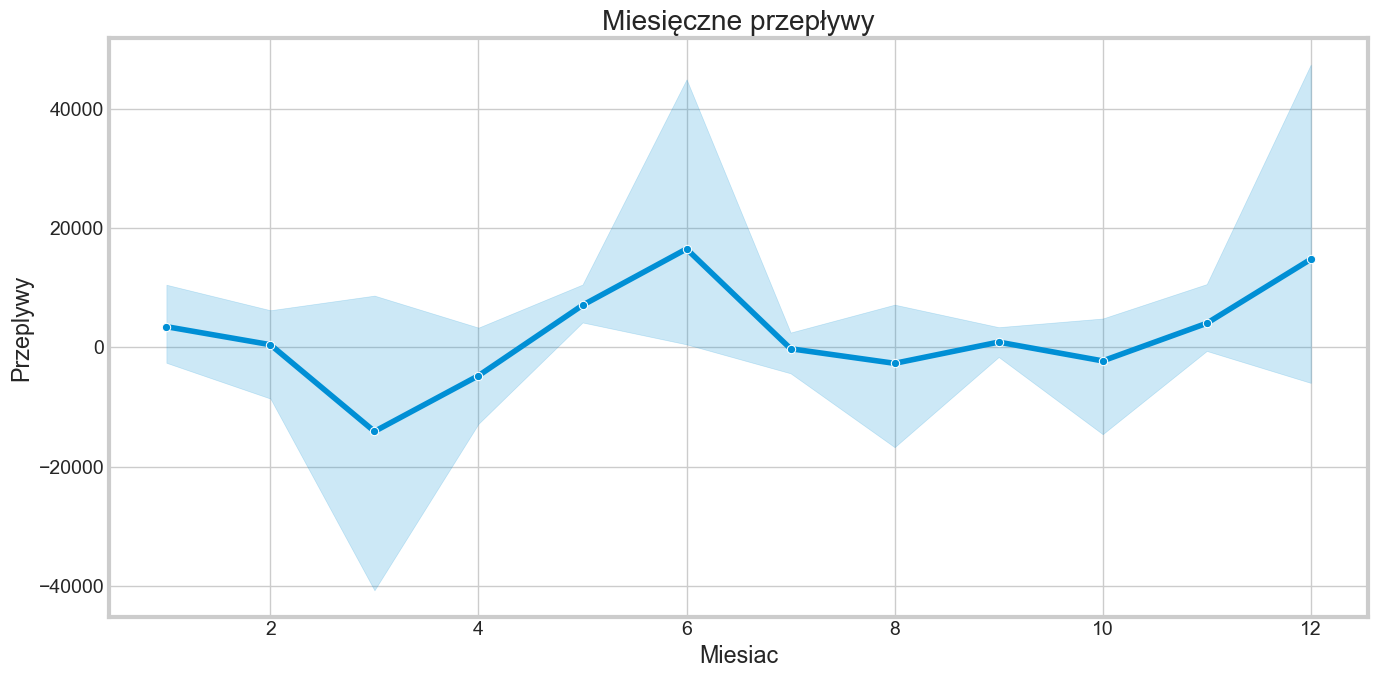

In [24]:
# Wykres miesięcznych przepływów
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_flow, x='Miesiac', y='Przeplywy', marker="o")
plt.title('Miesięczne przepływy')
plt.tight_layout()
plt.show()


In [25]:
# Stworzenie lokalnej bazy danych SQLite
conn = sqlite3.connect('transactions_db_temp.sqlite')
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Przygotowanie agregacji danych
query_monthly_expenses = """
SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki 
FROM transactions WHERE Rodzaj = 'Debit' 
GROUP BY Rok, Miesiac, Kategoria
"""

monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Poprawione obliczenie procentowego udziału kategorii w miesięcznych wydatkach
monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# Tworzenie monthly_expenses_structure
cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].sum().reset_index()
cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Wydatki': 'Suma_Wydatkow'})
monthly_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
monthly_expenses_structure['Procent_Struktury'] = monthly_expenses_structure['Wydatki'] / monthly_expenses_structure['Suma_Wydatkow'] * 100

monthly_expenses_structure.head(10)

,Rok,Miesiac,Kategoria,Wydatki,Procent,Suma_Wydatkow,Procent_Struktury
0,2019,11,alkohol,-120.86,9.804256,-1232.73,9.804256
1,2019,11,czynsz za mieszkanie,-517.74,41.999465,-1232.73,41.999465
2,2019,11,dowolne zakupy,-0.45,0.036504,-1232.73,0.036504
3,2019,11,"higiena, kosmetyki, fryzjer",-6.99,0.567034,-1232.73,0.567034
4,2019,11,"hobby, kino, teatr",-29.70,2.409287,-1232.73,2.409287
5,2019,11,jedzenie i picie,-185.25,15.027622,-1232.73,15.027622
6,2019,11,jedzenie i picie: na mieście,-182.33,14.790749,-1232.73,14.790749
7,2019,11,jedzenie i picie: niezdrowe,-16.57,1.344171,-1232.73,1.344171
8,2019,11,jedzenie i picie: zamawiane,-139.86,11.345550,-1232.73,11.345550
9,2019,11,pomoc innym,-24.37,1.976913,-1232.73,1.976913
